In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import random,os,glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D



ModuleNotFoundError: No module named 'tensorflow'

In [3]:
print(tf.__version__)

NameError: name 'tf' is not defined

----------------------

## Data Preoprocessing
#### Splitting each image into 70 50x50 smaller images

In [3]:
def product(*args, repeat=1):
    pools = [tuple(pool) for pool in args] * repeat
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield tuple(prod)

In [4]:
from PIL import Image
import os
def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = list(product(range(0, h-h%d, d), range(0, w-w%d, d)))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        img.crop(box).save(out)

In [8]:
k=pd.read_csv('one-indexed-files.txt',sep=' ')
file_names_list=list(k['name'])

In [9]:
for names in file_names_list:
    tile(names,'all','out',50)

In [17]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('out') if isfile(join('out', f))]

In [19]:
from skimage.filters import threshold_li
entropy_values_img1=[]
for k in range(len(onlyfiles)):
    ent=threshold_li(cv2.imread('out/'+onlyfiles[k],1))
    if ent >=180:
        os.remove('out/'+onlyfiles[k])
        

In [20]:
onlyfiles2 = [f for f in listdir('out') if isfile(join('out', f))]
len(onlyfiles2)

115860

#### Recreate the folders with the new images

In [21]:
onlyfiles3=[]
for el in onlyfiles2:
    el= 'out/'+el
    onlyfiles3.append(el)

In [23]:
import shutil, os
files = onlyfiles3
for f in files:
    if f[4:6]=='ca':
        shutil.move(f, 'out/cardboard')
    elif f[4:6]=='gl':
        shutil.move(f, 'out/glass')
    elif f[4:6]=='me':
        shutil.move(f, 'out/metal')
    elif f[4:6]=='pa':
        shutil.move(f, 'out/paper')
    elif f[4:6]=='pl':
        shutil.move(f, 'out/plastic')
    elif f[4:6]=='tr':
        shutil.move(f, 'out/trash')

-------------------------

## Neural Network
#### Create, train and fit our NN 

In [5]:
data_dir  = 'out'


In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.25)
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(50, 50),
        batch_size=500,
        class_mode='categorical',subset='training')
validation_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(50, 50),
        batch_size=500,
        class_mode='categorical',subset='validation')


Found 115860 images belonging to 6 classes.
Found 28962 images belonging to 6 classes.


In [7]:
labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [8]:
labels

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [9]:
model=Sequential()
#Convolution blocks

model.add(Conv2D(32,(5,5), padding='same',input_shape=(50,50,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(64,(5,5), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(32,(5,5), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

filepath="trained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [11]:

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']) 

In [12]:
model.fit_generator(
        train_generator,
        steps_per_epoch=50,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=8,workers=10,callbacks=callbacks_list)

Epoch 1/100
 7/50 [===>..........................] - ETA: 14s - loss: 1.5688 - acc: 0.3620
Epoch 00001: val_acc improved from -inf to 0.38050, saving model to trained_model.h5
50/50 [==============================] - 14s 281ms/step - loss: 1.6349 - acc: 0.3105 - val_loss: 1.5353 - val_acc: 0.3805
Epoch 2/100
 7/50 [===>..........................] - ETA: 14s - loss: 1.5268 - acc: 0.3806
Epoch 00002: val_acc improved from 0.38050 to 0.38550, saving model to trained_model.h5
50/50 [==============================] - 14s 274ms/step - loss: 1.5124 - acc: 0.3890 - val_loss: 1.5247 - val_acc: 0.3855
Epoch 3/100
 7/50 [===>..........................] - ETA: 15s - loss: 1.4981 - acc: 0.3789
Epoch 00003: val_acc did not improve from 0.38550
50/50 [==============================] - 15s 291ms/step - loss: 1.4720 - acc: 0.4160 - val_loss: 1.4961 - val_acc: 0.3820
Epoch 4/100
 6/50 [==>...........................] - ETA: 16s - loss: 1.4421 - acc: 0.4033
Epoch 00004: val_acc improved from 0.38550 to 0

In [13]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


## Test a New Image

#### Divide the test foto in sub-image

In [58]:
imagenumber= str(input('Quale immagine tra quelle presenti vuoi testare? Inserisci un numero da 1 a 28'))

Quale immagine tra quelle presenti vuoi testare? Inserisci un numero da 1 a 28 31


In [59]:
image='prova'+imagenumber+ '.jpeg'
image2= 'test-foto/'+image
tile(image,'test-foto','out-test',50) #immagine 50x50

#### Drop backgound Images


In [60]:
from os import listdir
from os.path import isfile, join
onlyfiles2 = [f for f in listdir('out-test') if isfile(join('out-test', f))]

In [61]:
import numpy as np
import cv2
from skimage.filters import threshold_li
entropy_values_img1=[]
for k in range(len(onlyfiles2)):
    ent=threshold_li(cv2.imread('out-test/'+onlyfiles2[k],1))
    if ent >=180:
        os.remove('out-test/'+onlyfiles2[k] )

In [62]:
onlyfiles3 = [f for f in listdir('out-test') if isfile(join('out-test', f))]

In [63]:
onlyfiles4=[]
for el in onlyfiles3:
    el= 'out-test/'+el
    onlyfiles4.append(el)

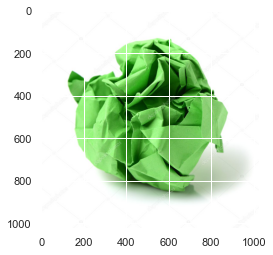

In [64]:
import matplotlib.pyplot as plt
from pylab import imread,subplot,imshow,show
im=imread(image2)
plt.imshow(im)

#### Make a Classification for each 50x50 Image and choose the class with most occurrences

Classified: cardboard


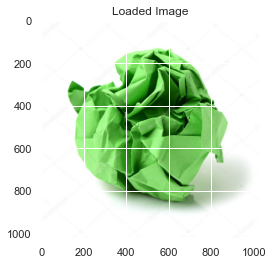

In [65]:
from tensorflow.keras.preprocessing import image
from statistics import mode
from PIL import Image
import glob
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )



class_prob=[]
for el in onlyfiles4:
    img_path = el

    img = image.load_img(img_path, target_size=(50, 50))
    img = image.img_to_array(img, dtype=np.uint8)
    img=np.array(img)/255.0
    p=model.predict(img[np.newaxis, ...])
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    class_prob.append(predicted_class)
    os.remove(el)
    
                             
                             
print("Classified:",mode(class_prob))

import matplotlib.pyplot as plt
from pylab import imread,subplot,imshow,show
im=imread(image2)
plt.title("Loaded Image")
plt.imshow(im);



In [66]:
from collections import Counter
Counter(class_prob).keys() 
Counter(class_prob).values()
c=Counter(class_prob)
j=dict([(i, c[i] / len(class_prob) * 100.0) for i in c])

In [67]:
import seaborn as sns

<AxesSubplot:>

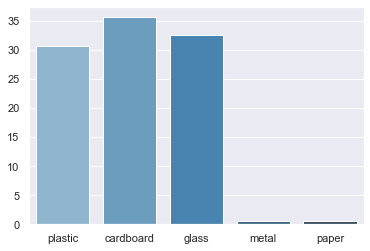

In [68]:
keys = list(j.keys())
vals = list(j.values())
sns.set_theme()
sns.barplot(x=keys, y=vals,palette="Blues_d")


-------------------------------------